# AMICI Python example "Experimental Conditions"
In this example we will explore some more options for the initialization of experimental conditions, including how to reset initial conditions based on changing values for fixedParameters as well as an additional presimulation phase on top of preequilibration. This notebook is expected to run from the `python/example_presimulation` directory.

In [1]:
# SBML model we want to import
sbml_file = 'model_presimulation.xml'
# Name of the model that will also be the name of the python module
model_name = 'model_presimulation'
# Directory to which the generated model code is written
model_output_dir = model_name

import libsbml
import amici
import amici.plotting
import os
import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Model Loading
Here we load a simple model of protein phosphorylation that can be inhibited by a drug. This model was created using PySB (see `createModel.py`)

In [2]:
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()
dir(sbml_doc)

print('Species: ', [(s.getId(),s.getName()) for s in sbml_model.getListOfSpecies()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getName(), 
                        reactants,
                        reversible,
                         products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))
    
print('Parameters: ', [(p.getId(),p.getName()) for p in sbml_model.getListOfParameters()])

Species:  [('__s0', "PROT(kin=None, drug=None, phospho='u')"), ('__s1', 'DRUG(bound=None)'), ('__s2', 'KIN(bound=None)'), ('__s3', "DRUG(bound=1) ._br_PROT(kin=None, drug=1, phospho='u')"), ('__s4', "KIN(bound=1) ._br_PROT(kin=1, drug=None, phospho='u')"), ('__s5', "PROT(kin=None, drug=None, phospho='p')")]

Reactions:
PROT_DRUG_bind:  __s0 +  __s1 <->      __s3		[-(koff_prot_drug * __s3) + kon_prot_drug * __s0 * __s1]
PROT_KIN_bind:  __s0 +  __s2  ->      __s4		[kon_prot_kin * __s0 * __s2]
PROT_KIN_phospho:       __s4  -> __s2 +  __s5		[kphospho_prot_kin * __s4]
PROT_dephospho:       __s5  ->      __s0		[kdephospho_prot * __s5]
Parameters:  [('initProt', 'initProt'), ('initDrug', 'initDrug'), ('initKin', 'initKin'), ('pPROT_obs', 'pPROT_obs'), ('PROT_0', 'PROT_0'), ('DRUG_0', 'DRUG_0'), ('KIN_0', 'KIN_0'), ('kon_prot_drug', 'kon_prot_drug'), ('koff_prot_drug', 'koff_prot_drug'), ('kon_prot_kin', 'kon_prot_kin'), ('kphospho_prot_kin', 'kphospho_prot_kin'), ('kdephospho_prot', 'kdephosp

In [3]:
# Create an SbmlImporter instance for our SBML model
sbml_importer = amici.SbmlImporter(sbml_file)

For this example we want specify the initial drug and kinase concentrations as experimental conditions. Accordingly we specify them as fixedParameters. The meaning of fixedParameters is defined in the [Glossary](https://amici.readthedocs.io/en/latest/glossary.html#term-fixed-parameters), which we display here for convenience.

In [4]:
from IPython.display import IFrame
IFrame('https://amici.readthedocs.io/en/latest/glossary.html#term-fixed-parameters', width=600, height=175)

In [5]:
fixedParameters = ['DRUG_0','KIN_0']

The SBML model specifies a single observable named `pPROT` which describes the fraction of phosphorylated Protein. We load this observable using [amici.assignmentRules2observables](https://amici.readthedocs.io/en/latest/generated/amici.sbml_import.html#amici.sbml_import.assignmentRules2observables).

In [6]:
# Retrieve model output names and formulae from AssignmentRules and remove the respective rules
observables = amici.assignmentRules2observables(
        sbml_importer.sbml, # the libsbml model object
        filter_function=lambda variable: variable.getName() == 'pPROT' 
    )
print('Observables:', observables)

Observables: {'__obs0': {'name': 'pPROT', 'formula': '__s5'}}


Now the model is ready for compilation using [sbml2amici](https://amici.readthedocs.io/en/latest/generated/amici.sbml_import.SbmlImporter.html#amici.sbml_import.SbmlImporter.sbml2amici). Note that we here pass `fixedParameters` as arguments to `constant_parameters`, which ensures that amici is aware that we want to have them as fixedParameters:

In [7]:
sbml_importer.sbml2amici(model_name, 
                         model_output_dir, 
                         verbose=False,
                         observables=observables,
                         constant_parameters=fixedParameters)
sys.path.insert(0, os.path.abspath(model_output_dir))
# load the compiled module
model_module = importlib.import_module(model_name)

To simulate the model we need to create an instance via the `getModel()` method in the generated model module.

In [8]:
# Create Model instance
model = model_module.getModel()
# set timepoints for which we want to simulate the model


# Create solver instance
solver = model.getSolver()

The only thing we need to simulate the model is a timepoint vector, which can be specified using the [setTimepoints](https://amici.readthedocs.io/en/latest/generated/amici.amici.Model.html#amici.amici.Model.setTimepoints) method. If we do not specify any additional options, the default values for fixedParameters and Parameters that were specified in the SBML file will be used.

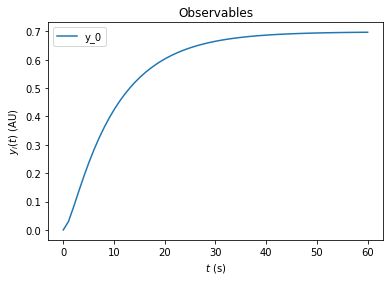

In [9]:
# Run simulation using default model parameters and solver options
model.setTimepoints(np.linspace(0, 60, 60)) 
rdata = amici.runAmiciSimulation(model, solver)
amici.plotting.plotObservableTrajectories(rdata)

Simulation options can be specified either in the [Model](https://amici.readthedocs.io/en/latest/generated/amici.amici.Model.html) or in an [ExpData](https://amici.readthedocs.io/en/latest/generated/amici.amici.ExpData.html) object. The ExpData object can also carry experimental data. To initialize an ExpData object from simulation routines, amici offers some [convenient constructors](https://amici.readthedocs.io/en/latest/generated/amici.amici.ExpData.html#amici.amici.ExpData). In the following we will initialize an ExpData object from simulation results, but add noise with standard deviation `0.1` and specify the standard deviation accordingly. Moreover, we will specify custom values for `DRUG_0=0` and `KIN_0=2`. If fixedParameter is specfied in an ExpData object, [runAmiciSimulation](https://amici.readthedocs.io/en/latest/generated/amici.html#amici.runAmiciSimulation) will use those parameters instead of the ones specified in the Model object.

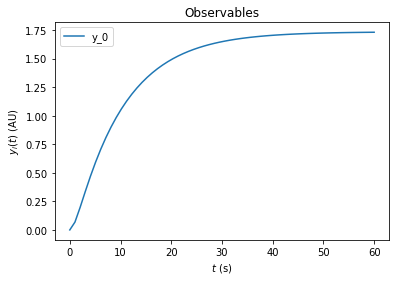

In [10]:
edata = amici.ExpData(rdata, 0.1, 0.0)
edata.fixedParameters = [0,2]
rdata = amici.runAmiciSimulation(model, solver, edata)
amici.plotting.plotObservableTrajectories(rdata)

For many biological systems, it is reasonable to assume that they start in a
 steady state. In this example we want to specify an experiment where a pretreatment with a drug is performed _before_ the kinase is added. We assume that the pretreatment is sufficiently long such that the system reaches steadystate before the kinase is added. To implement this in amici, we can specify `fixedParametersPreequilibration` in the ExpData object. This automatically adds a preequilibration phase where the model is run to steadystate, before regular simulation starts. Here we set `DRUG_0=3` and `KIN_0=0` for the preequilibration. This means that there is no kinase available in the preequilibration phase. 

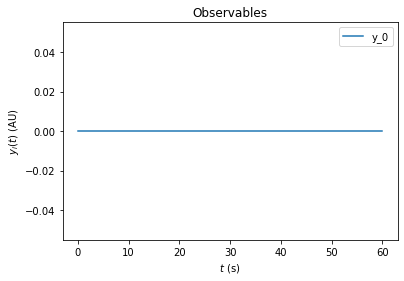

In [11]:
edata.fixedParametersPreequilibration = [3,0]
rdata = amici.runAmiciSimulation(model, solver, edata)
amici.plotting.plotObservableTrajectories(rdata)

The resulting trajectory is definitely not what one may expect. The problem is that the `DRUG_0` and `KIN_0` set initial condtions for species in the model. By default these initial conditions are only applied at the very beginning of the simulation, i.e., before the preequilibration. Accordingly, the fixedParameters that we specified do not have any effect. To fix this, we need to use [reinitializeAllFixedParameterDependentInitialStates](https://amici.readthedocs.io/en/latest/generated/amici.amici.ExpData.html#amici.amici.ExpData.reinitializeAllFixedParameterDependentInitialStates) to ensure that AMICI is aware that the respective initial states accounts for fixedParameter dependent changes to the initial conditions between preequilibration and simulation.

In [12]:
edata.reinitializeAllFixedParameterDependentInitialStates(model.nx_rdata)

With this option activated, the kinase concentration will be reinitialized after the preequilibration and we will see the expected change in fractional phosphorylation:

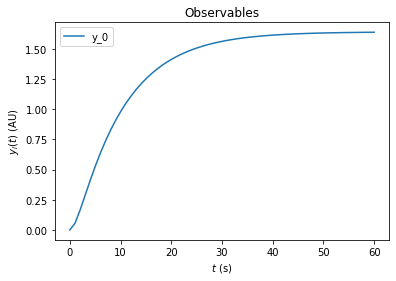

In [13]:
rdata = amici.runAmiciSimulation(model, solver, edata)
amici.plotting.plotObservableTrajectories(rdata)

On top of preequilibration, we can also specify presimulation. This option can be used to specify pretreatments where the system is not assumed to reach steadystate. Presimulation can be activated by specifying `t_presim` and `edata.fixedParametersPresimulation`. If both `fixedParametersPresimulation` and `fixedParametersPreequilibration` are specified, preequilibration will be performed first, followed by presimulation, followed by regular simulation. For this example we specify `DRUG_0=10` and `KIN_0=0` for the presimulation and `DRUG_0=10` and `KIN_0=2` for the regular simulation. We do not overwrite the `DRUG_0=3` and `KIN_0=0` that was previously specified for preequilibration.

(3.0, 0.0)
(10.0, 0.0)
(10.0, 2.0)


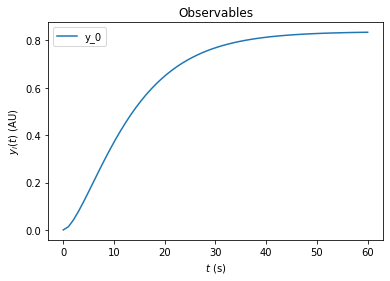

In [14]:
edata.t_presim = 10
edata.fixedParametersPresimulation = [10.0,0.0]
edata.fixedParameters = [10.0,2.0]
print(edata.fixedParametersPreequilibration)
print(edata.fixedParametersPresimulation)
print(edata.fixedParameters)
rdata = amici.runAmiciSimulation(model, solver, edata)
amici.plotting.plotObservableTrajectories(rdata)